<span style="font-family: Times New Roman;font-size: 20px"> 
Firstly, required libraries are imported. pandas library is used for data manipulation and analysis, while functions from nltk library are used for text processing: word_tokenize is used for tokenization, stopwords is used for removing stopwords, and WordNetLemmatizer is used for lemmatization. In following, gensim is used for Word2Vec model. matplotlib.pyplot is used for plotting. Also, cosine_similarity is used for calculating cosine similarity between two vectors while dendogram and linkage are used for hierarchical clustering.

In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
import gensim.downloader as api
from gensim.models import word2vec
from simalign import SentenceAligner
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage

<span style="font-family: Times New Roman;font-size: 20px"> 
After importing required libraries, data is imported. Data is acquired by Gutenberg Project as discussed in previous chapters and saved as txt files.

In [2]:
Dutch = open('Dutch.txt').read()
English = open('English.txt').read()
Finnish = open('Finnish.txt').read()
German = open('German.txt').read()
Italian = open('Italian.txt').read()
languages = [Dutch, English, Finnish, German, Italian]
names = ['Dutch', 'English', 'Finnish', 'German', 'Italian']

<span style="font-family: Times New Roman;font-size: 20px"> 
This is followed by lemmatization and tokenization processes. Lemmatization is grouping together the inflected forms of words to analyze them as a single item, while tokenization is the process of breaking a stream of text up into words, phrases, symbols, or other meaningful elements called tokens. Tokenization is followed by removal of stopwords from the dataset. This processed datasets are saved as tokenized_"language_name" variables.


In [3]:
def data_tokenizer(language, language_name, encoding = 'utf-8'):
    lemmatized = WordNetLemmatizer().lemmatize(language)
    tokenized = nltk.word_tokenize(lemmatized)
    f=[word.lower() for word in tokenized if word.isalpha()]
    stop_words = set(nltk.corpus.stopwords.words(language_name))
    [stopped] = [[i for i in j if i not in stop_words] for j in [f]]
    return stopped

tokenized_Dutch = data_tokenizer(Dutch,'Dutch')
tokenized_English = data_tokenizer(English,'English')
tokenized_Finnish = data_tokenizer(Finnish,'Finnish')
tokenized_German = data_tokenizer(German,'German')
tokenized_Italian = data_tokenizer(Italian,'Italian')
tokenized_names = 'tokenized_'+pd.Series(names)
tokenized_languages = [tokenized_Dutch, tokenized_English, tokenized_Finnish, tokenized_German, tokenized_Italian]

<span style="font-family: Times New Roman;font-size: 20px"> 
For more consistent models, only most common 50 words are selected and used for further analysis. This is done by using most_common_words function. This function takes a list and transforms it to a dataset, then counts the number of words and sorts them in descending order. Finally, it returns the most common 50 words.

In [4]:
def most_common_words(lang):
    df = pd.DataFrame(lang, columns = ['Language'])
    df_sorted = df.groupby(['Language'])['Language'].count().reset_index(
                        name='Count').sort_values(['Count'], ascending=False)
    return df_sorted.Language[:50].reset_index(drop=True)

Dutch_most_common = most_common_words(tokenized_Dutch)
English_most_common = most_common_words(tokenized_English)
Finnish_most_common = most_common_words(tokenized_Finnish)
German_most_common = most_common_words(tokenized_German)
Italian_most_common = most_common_words(tokenized_Italian)
most_common_names = 'most_common_'+pd.Series(names)
most_common_languages = [Dutch_most_common, English_most_common, Finnish_most_common, German_most_common, Italian_most_common]
most_common_words_ = pd.DataFrame(most_common_languages).T
most_common_words_.columns = most_common_names

<span style="font-family: Times New Roman;font-size: 20px"> 
Most common words can are as following:

In [5]:
most_common_words_.head(10)

,most_common_Dutch,most_common_English,most_common_Finnish,most_common_German,most_common_Italian
0,den,thou,ma,sprach,ch
1,gij,one,mi,sah,sì
2,zoo,thee,mut,drum,de
3,zóó,unto,näin,schon,d
4,wanneer,upon,sa,mehr,s
5,zeide,said,mun,wohl,quel
6,wij,thy,jo,ward,me
7,waar,us,mulle,licht,poi
8,mijne,made,min,gleich,così
9,oogen,eyes,kaikki,wer,là


<span style="font-family: Times New Roman;font-size: 20px"> 
After that, most common 50 words are aligned between each other to be used in word2vec model. This is done by alingment function. This function takes a language and alings it with English. It returns aligned_"language_name" variables. While aligning, mwmf key is used because it has the best results.

In [6]:
aligner =  SentenceAligner(model="bert", token_type="bpe", matching_methods="mai")
def alingment(language):
    aligned = aligner.get_word_aligns(English_most_common.to_list(), language.to_list())
    mwmf = pd.DataFrame(aligned['mwmf'])
    return language.reindex(mwmf[0]).reset_index(drop=True)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
2023-06-08 17:10:41,285 - simalign.simalign - INFO - Initialized the EmbeddingLoader with model: bert-base-multilingual-cased


In [7]:
Dutch_aligned = alingment(Dutch_most_common)
English_aligned = alingment(English_most_common)
Finnish_aligned = alingment(Finnish_most_common)
German_aligned = alingment(German_most_common)
Italian_aligned = alingment(Italian_most_common)
aligned_names = 'aligned_'+pd.Series(names)
aligned_languages = [Dutch_aligned, English_aligned, Finnish_aligned, German_aligned, Italian_aligned]
Aligned_DataFrame = pd.DataFrame(aligned_languages).T
Aligned_DataFrame.columns = names

<span style="font-family: Times New Roman;font-size: 20px"> 
After aligning, most common 10 aligned words are as following:

In [8]:
Aligned_DataFrame.head(10)

,Dutch,English,Finnish,German,Italian
0,den,thou,ma,sprach,ch
1,den,one,ma,sprach,ch
2,gij,thee,mi,sah,sì
3,zoo,unto,mut,drum,de
4,zóó,upon,näin,drum,d
5,wanneer,said,sa,schon,d
6,zeide,thy,mun,schon,s
7,wij,us,jo,mehr,quel
8,wij,made,jo,wohl,me
9,waar,eyes,mulle,ward,poi


<span style="font-family: Times New Roman;font-size: 20px"> 
This aligned words are going to be used in Word2Vec model. There will be 2 Word2Vec models for each language. One will be trained with Skip-Gram, while other will be trained with CBOW.

In [9]:
def skipgram(language):
    return gensim.models.Word2Vec(language, vector_size = 50, sg = 1).wv
def cbow(language):
    return gensim.models.Word2Vec(language, vector_size = 50,sg = 0).wv

skipgram_Dutch = skipgram(Dutch_aligned)
skipgram_English = skipgram(English_aligned)
skipgram_Finnish = skipgram(Finnish_aligned)
skipgram_German = skipgram(German_aligned)
skipgram_Italian = skipgram(Italian_aligned)

cbow_Dutch = cbow(Dutch_aligned)
cbow_English = cbow(English_aligned)
cbow_Finnish = cbow(Finnish_aligned)
cbow_German = cbow(German_aligned)
cbow_Italian = cbow(Italian_aligned)

<span style="font-family: Times New Roman;font-size: 20px"> 
For using Word2Vec model in clustering, each word must be represented by a vector instead of a matrix. Due to that, following <b> flat() </b> function is for flattening the language matrices. This function takes the language matrix, and transforms it into a list. After that, it flattens the list and returns it.

In [10]:
def flat(model):
    vocab = list(model.index_to_key)
    vectors = model[vocab]
    vectors_flatten = vectors.flatten()
    return vectors_flatten

<span style="font-family: Times New Roman;font-size: 20px"> 
In this part, Skip-Gram model will be used for clustering. Firstly, each language is flattened and saved as an array. After that, those vectors are combined as a dataframe named skipgram. Names of the languages is index of this dataset and and columns are corresponding vectors. NaN values are droppen to being able to use the dataframe in clustering.

In [11]:
flat_skipgram_Dutch = flat(skipgram_Dutch)
flat_skipgram_English = flat(skipgram_English)
flat_skipgram_Finnish = flat(skipgram_Finnish)
flat_skipgram_German = flat(skipgram_German)
flat_skipgram_Italian = flat(skipgram_Italian)
skipgram = pd.DataFrame([flat_skipgram_Dutch, flat_skipgram_English, flat_skipgram_Finnish, flat_skipgram_German, flat_skipgram_Italian],index=names).dropna(axis=1)

<span style="font-family: Times New Roman;font-size: 20px"> 
After creating skipgram dataframe, cosine similarity is calculated for the dataset. This metric returns cosine value of angle between two vectors. If this cosine value is 1, it means that two vectors are identical. If it is 0, it means that two vectors are orthogonal. If it is -1, it means that two vectors are opposite of each other. After calculating cosine similarity, linkage is used for hierarchical clustering. This linkage function takes cosine similarity as input and returns a linkage matrix. Linkage matrix is a matrix that contains information about hierarchical clustering. This is followed by plotting dendogram. Dendogram is a tree diagram that shows the arrangement of the clusters produced by hierarchical clustering. X label of the dendogram is the languages, while Y label is the distance between clusters. The dendogram can be seen below.

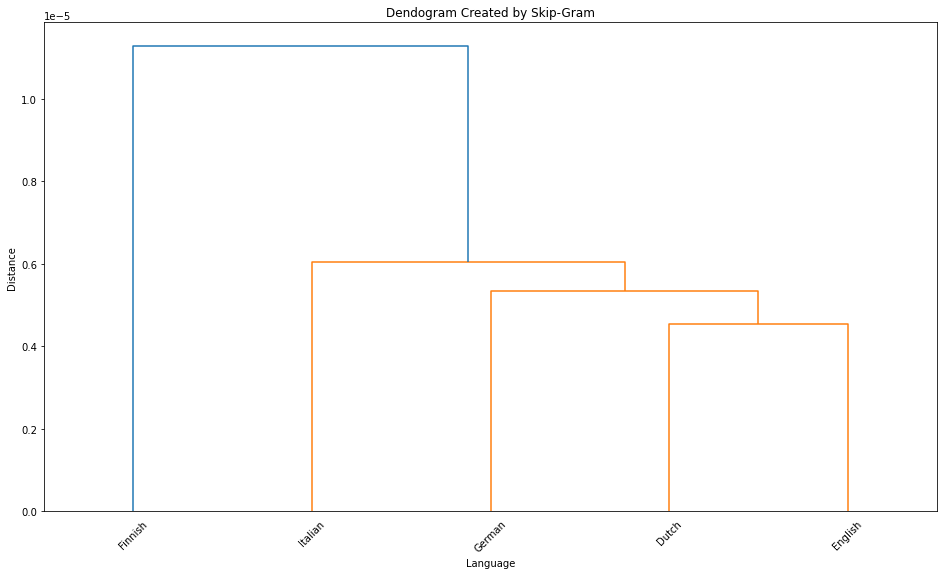

In [12]:
skipgram_similarity = cosine_similarity(skipgram)
Z = linkage(skipgram_similarity, 'ward')
plt.figure(figsize=(16, 9))
dendrogram(Z, leaf_rotation=90, leaf_font_size=7., labels = skipgram.index)
plt.title('Dendogram Created by Skip-Gram')
plt.ylabel('Distance')
plt.xlabel('Language')
plt.xticks(rotation = 45, fontsize = 10)

plt.show()

<span style="font-family: Times New Roman;font-size: 20px"> 
As it can be seen in the dendogram, Finnish is clustered different from other 4 languages. This is caused by the fact that Finnish is not an Indo-European language. Finnish is an Uralic language, which is a language family that contains languages such as Hungarian and Estonian. Furthermore, Italian is also clustered different from other 3 languages. This is caused by the fact that Italian is a Romance language, which is a language family that contains languages such as Spanish and French. Finally, Dutch and English is clustered together instead of German. This is caused by the fact that Dutch and English are West Germanic languages, while German is a High Germanic language. Thanks to these results, it can be said that clustering by Skip-Gram algorithm is successful. 

<span style="font-family: Times New Roman;font-size: 20px"> 
After Skip-Gram, CBOW model will be used for clustering. Firstly, each language is flattened and saved as an array. After that, those vectors are combined as a dataset named cbow. Names of the languages is index of this dataset and and columns are corresponding vectors. To use in clustering, NaN values are dropped.

In [13]:
flat_cbow_Dutch = flat(cbow_Dutch)
flat_cbow_English = flat(cbow_English)
flat_cbow_Finnish = flat(cbow_Finnish)
flat_cbow_German = flat(cbow_German)
flat_cbow_Italian = flat(cbow_Italian)
cbow = pd.DataFrame([flat_cbow_Dutch, flat_cbow_English, flat_cbow_Finnish, flat_cbow_German, flat_cbow_Italian],index=names).dropna(axis=1)

<span style="font-family: Times New Roman;font-size: 20px"> 
cbow dataframe is used to calculate cosine similarity with the function cosine_similarity. While this section of the code is same with the previous one, it is repeated to be able to compare results. After calculating cosine similarity, linkage is used for hierarchical clustering. This linkage function takes cosine similarity as input and returns a linkage matrix. This is followed by plotting dendogram. Dendogram is a tree diagram that shows the arrangement of the clusters produced by hierarchical clustering. Labels are same as Skip-Gram dendogram: X label of the dendogram is the languages, while Y label is the distance between clusters. The dendogram can be seen below.

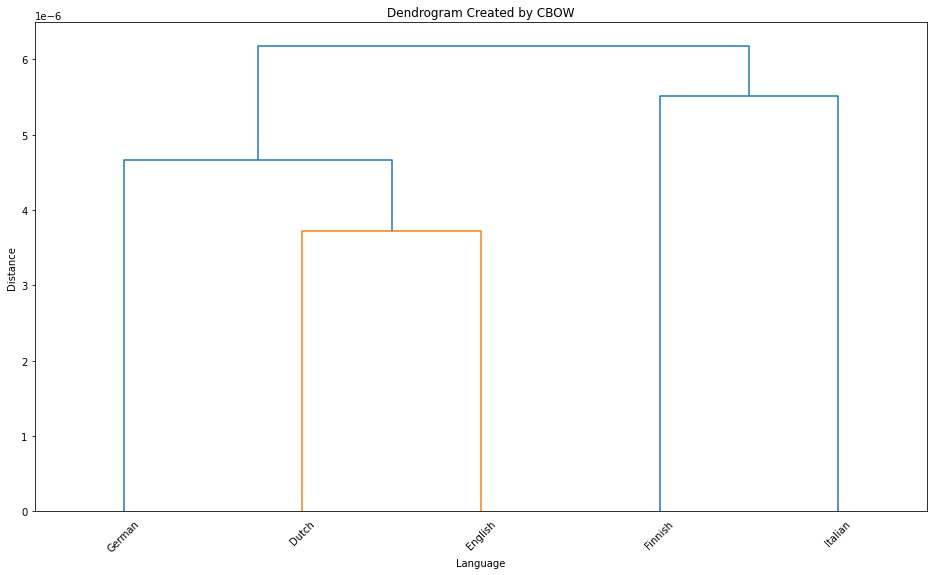

In [14]:
cbow_similarity = cosine_similarity(cbow)
Z_cbow = linkage(cbow_similarity, 'ward')
plt.figure(figsize=(16, 9))
dendrogram(Z_cbow, leaf_rotation=90, leaf_font_size=7., labels = cbow.index)
plt.title('Dendrogram Created by CBOW')
plt.ylabel('Distance')
plt.xlabel('Language')
plt.xticks(rotation = 45, fontsize = 10)
plt.show()

<span style="font-family: Times New Roman;font-size: 20px"> 
In this dendogram, it can be seen that Dutch and English are clustered close to each other and German is the closest language to them. This relationship caused by the same reason as Skip-Gram dendogram: While Dutch and English are West Germanic languages, German is a High Germanic language. Furthermore, instead of being clustered with other Indo-European languages, Italian is clustered with Uralic language Finnish in this dendogram. This mistake might be caused by morphological similarity between Italian and Finnish. Instead of generating surrounding words from center word, CBOW model generates center word from surrounding words, and that might cause to morphological similarity of those two languages to effect clustering. Finally, it can be seen that except Italian, the clustering is same as Skip-Gram dendogram. Thanks to these results, it can be said that clustering by CBOW algorithm partially successful.